In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import xgcm
import xarray as xr
import sectionate
import regionate
import matplotlib.pyplot as plt

## Creating mask

In [3]:
from example_dataset_grids import load_OM4p5
ds, grid = load_OM4p5("sigma2", z_coord="natv")

In [5]:
ds['mask'] = (
    (ds['deptho'] <= 1000.) &
    (ds['geolat'] <= -57.5)
)

In [6]:
from regionate import MaskRegions, GriddedRegion
regions = MaskRegions(ds.mask, grid).regions

In [7]:
antarctic = regions[0]
region = GriddedRegion("antarctic", antarctic.lons, antarctic.lats, grid, ij=(antarctic.i, antarctic.j))

/vftmp/Henri.Drake/pid14796/ipykernel_24831/4031526429.py:9: UserWarning: No contour levels were found within the data range.
  plt.contour(
/vftmp/Henri.Drake/pid14796/ipykernel_24831/4031526429.py:26: UserWarning: No contour levels were found within the data range.
  plt.contour(


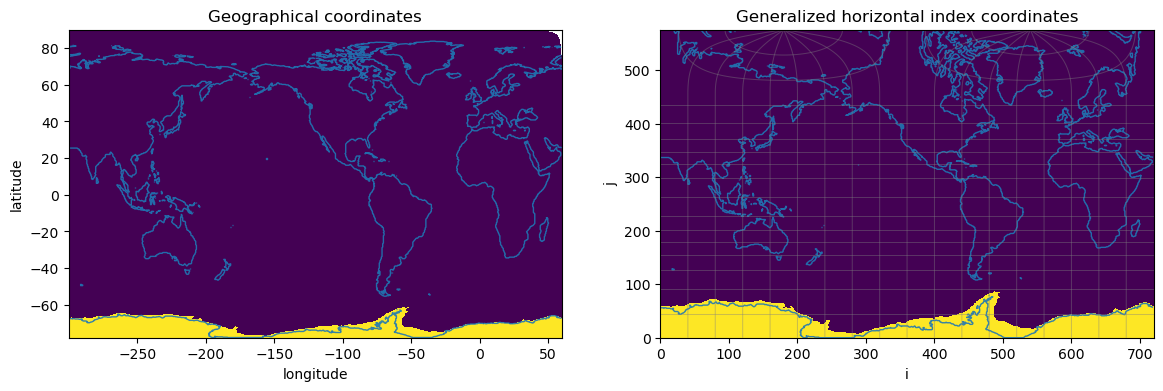

In [29]:
plt.figure(figsize=(14, 4))
plt.subplot(1,2,1)
plt.pcolor(
    ds.geolon_c,
    ds.geolat_c,
    region.mask,
    vmin=0.2, vmax=1.
)
plt.contour(
    ds.geolon,
    ds.geolat,
    ds.deptho,
    levels=[0.],
    colors="C0",
    linewidths=1.,
    alpha=0.9
)
plt.title("Geographical coordinates")
plt.xlabel("longitude")
plt.ylabel("latitude")

plt.subplot(1,2,2)
plt.pcolor(
    region.mask
)
plt.contour(
    ds.deptho,
    levels=[0.],
    colors="C0",
    linewidths=1.,
    alpha=0.9
)
dlon=20.
plt.contour(
    ds['geolon_c'],
    colors="grey",
    linestyles="solid",
    linewidths=0.75,
    alpha=0.4,
    levels=np.arange(-300., 60.+dlon, dlon)
)

dlat = 10.
plt.contour(
    ds['geolat_c'],
    colors="grey",
    linestyles="solid",
    linewidths=0.75,
    alpha=0.4,
    levels=np.arange(-90., 90.+dlat, dlat)
);
plt.title("Generalized horizontal index coordinates")
plt.xlabel("i")
plt.ylabel("j");

### Plotting budgets

In [208]:
rho_ref = 1035.
toSv = 1.e-6/rho_ref

wmbs = {}
for lam in ["heat", "salt", "sigma2"]:
    wmbs[lam] = xr.open_dataset(f"/work/hfd/codedev/xwmb/data/budget_antarctic_{lam}.nc")
    wmbs[lam]["tendency"] += wmbs[lam]["surface_mass_flux"]
    wmbs[lam]["boundary_forcing"] += wmbs[lam]["surface_mass_flux"]
    wmbs[lam]["external_forcing"] += wmbs[lam]["surface_mass_flux"]
    wmbs[lam]["diabatic_forcing"] += wmbs[lam]["surface_mass_flux"]
    
    wmbs[lam]['numerical_mixing'] = (
        +wmbs[lam].advection
        +wmbs[lam].overturning
        +wmbs[lam].mass_source
        -wmbs[lam].residual_mass_tendency
    )

    wmbs[lam]['volume_discretization_error'] = (
        +wmbs[lam].residual_mass_tendency
        -wmbs[lam].mass_tendency
        -wmbs[lam].tendency
    )
            
    wmbs[lam]['numerical_errors'] = (
        +wmbs[lam].advection
        +wmbs[lam].overturning
        +wmbs[lam].mass_source
        -wmbs[lam].mass_tendency
        -wmbs[lam].tendency
    )

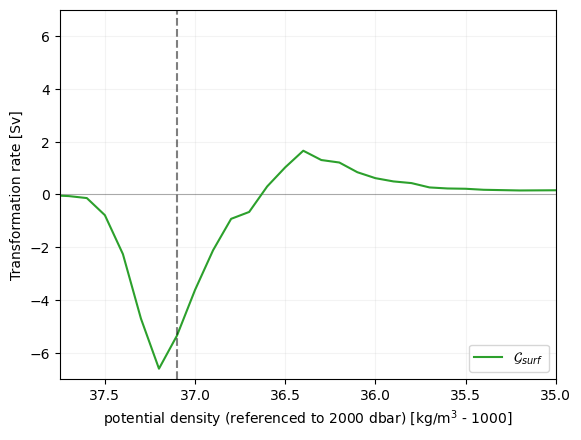

In [209]:
wmt = wmbs["sigma2"] 

plt.axhline(0., color="k", alpha=0.3, lw=0.8)

#(wmt['mass_tendency']*toSv).mean('time').plot(label=r"$\partial_{t} \mathcal{V}$", color="C0")
#(-wmt['overturning']*toSv).mean('time').plot(label=r"$-\Psi$", color="C1")
(wmt['boundary_forcing']*toSv).mean('time').plot(label=r"$\mathcal{G}_{surf}$", color="C2")
#(wmt['diffusion']*toSv).mean('time').plot(label=r"$\mathcal{G}_{diff}$", color="C3")
#(wmt['numerical_errors']*toSv).mean('time').plot(label=r"$\mathcal{N}\equiv \mathcal{N}_{A} + \mathcal{N}_{T}$", color="C4")
#(-wmt['mass_source']*toSv).mean('time').plot(label=r"$-\mathcal{S}$", color="C5")
#(wmt['geothermal']*toSv).mean('time').plot(label=r"$\mathcal{G}_{geo}$", color="C6")
#(wmt['frazil_ice']*toSv).mean('time').plot(label=r"$\mathcal{G}_{frazil}$", color="C7")

plt.legend()
plt.grid(True, alpha=0.15)
plt.ylabel("Transformation rate [Sv]")
plt.xlabel(r"potential density (referenced to 2000 dbar) [kg/m$^3$ - 1000]");

sigma2_max_overturning = (-wmt['overturning']).mean('time').idxmax()
plt.axvline(sigma2_max_overturning, color="k", linestyle="--", alpha=0.5)
plt.xlim(37.75, 35)
plt.ylim(-7, 7)
plt.legend(loc="lower right")

plt.savefig("../ncar_figures/antarctic_wmb_0", bbox_inches="tight", dpi=150)

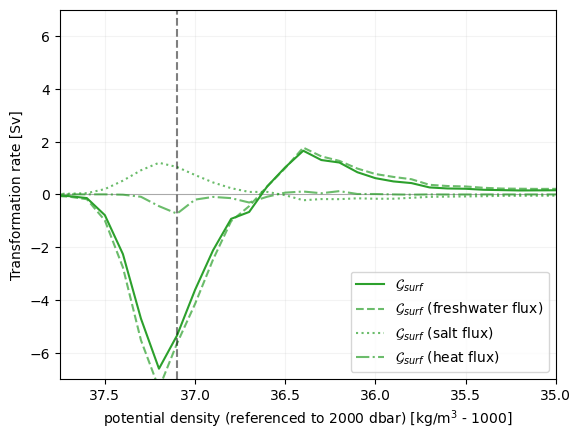

In [210]:
wmt = wmbs["sigma2"] 

plt.axhline(0., color="k", alpha=0.3, lw=0.8)

#(wmt['mass_tendency']*toSv).mean('time').plot(label=r"$\partial_{t} \mathcal{V}$", color="C0")
#(-wmt['overturning']*toSv).mean('time').plot(label=r"$-\Psi$", color="C1")
(wmt['boundary_forcing']*toSv).mean('time').plot(label=r"$\mathcal{G}_{surf}$", color="C2")
(wmt['surface_mass_flux']*toSv).mean('time').plot(label=r"$\mathcal{G}_{surf}$ (freshwater flux)", color="C2", ls="--", alpha=0.7)
(wmt['boundary_forcing_salt']*toSv).mean('time').plot(label=r"$\mathcal{G}_{surf}$ (salt flux)", color="C2", ls=":", alpha=0.7)
(wmt['boundary_forcing_heat']*toSv).mean('time').plot(label=r"$\mathcal{G}_{surf}$ (heat flux)", color="C2", ls="-.", alpha=0.7)


#(wmt['diffusion']*toSv).mean('time').plot(label=r"$\mathcal{G}_{diff}$", color="C3")
#(wmt['numerical_errors']*toSv).mean('time').plot(label=r"$\mathcal{N}\equiv \mathcal{N}_{A} + \mathcal{N}_{T}$", color="C4")
#(-wmt['mass_source']*toSv).mean('time').plot(label=r"$-\mathcal{S}$", color="C5")
#(wmt['geothermal']*toSv).mean('time').plot(label=r"$\mathcal{G}_{geo}$", color="C6")
#(wmt['frazil_ice']*toSv).mean('time').plot(label=r"$\mathcal{G}_{frazil}$", color="C7")

plt.legend()
plt.grid(True, alpha=0.15)
plt.ylabel("Transformation rate [Sv]")
plt.xlabel(r"potential density (referenced to 2000 dbar) [kg/m$^3$ - 1000]");

sigma2_max_overturning = (-wmt['overturning']).mean('time').idxmax()
plt.axvline(sigma2_max_overturning, color="k", linestyle="--", alpha=0.5)
plt.xlim(37.75, 35)
plt.ylim(-7, 7)
plt.legend(loc="lower right")

plt.savefig("../ncar_figures/antarctic_wmb_0_decomposed", bbox_inches="tight", dpi=150)

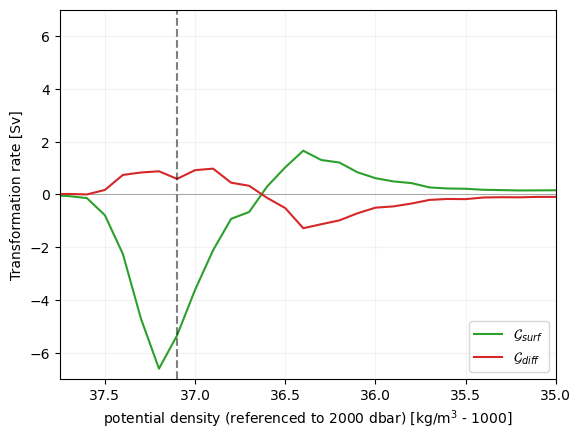

In [211]:
wmt = wmbs["sigma2"] 

plt.axhline(0., color="k", alpha=0.3, lw=0.8)

#(wmt['mass_tendency']*toSv).mean('time').plot(label=r"$\partial_{t} \mathcal{V}$", color="C0")
#(-wmt['overturning']*toSv).mean('time').plot(label=r"$-\Psi$", color="C1")
(wmt['boundary_forcing']*toSv).mean('time').plot(label=r"$\mathcal{G}_{surf}$", color="C2")
(wmt['diffusion']*toSv).mean('time').plot(label=r"$\mathcal{G}_{diff}$", color="C3")
#(wmt['numerical_errors']*toSv).mean('time').plot(label=r"$\mathcal{N}\equiv \mathcal{N}_{A} + \mathcal{N}_{T}$", color="C4")
#(-wmt['mass_source']*toSv).mean('time').plot(label=r"$-\mathcal{S}$", color="C5")
#(wmt['geothermal']*toSv).mean('time').plot(label=r"$\mathcal{G}_{geo}$", color="C6")
#(wmt['frazil_ice']*toSv).mean('time').plot(label=r"$\mathcal{G}_{frazil}$", color="C7")

plt.legend()
plt.grid(True, alpha=0.15)
plt.ylabel("Transformation rate [Sv]")
plt.xlabel(r"potential density (referenced to 2000 dbar) [kg/m$^3$ - 1000]");

sigma2_max_overturning = (-wmt['overturning']).mean('time').idxmax()
plt.axvline(sigma2_max_overturning, color="k", linestyle="--", alpha=0.5)
plt.xlim(37.75, 35)
plt.ylim(-7, 7)
plt.legend(loc="lower right")

plt.savefig("../ncar_figures/antarctic_wmb_1", bbox_inches="tight", dpi=150)

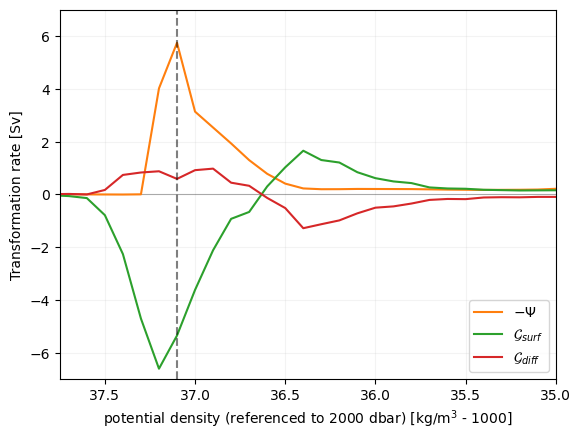

In [212]:
wmt = wmbs["sigma2"] 

plt.axhline(0., color="k", alpha=0.3, lw=0.8)

#(wmt['mass_tendency']*toSv).mean('time').plot(label=r"$\partial_{t} \mathcal{V}$", color="C0")
(-wmt['overturning']*toSv).mean('time').plot(label=r"$-\Psi$", color="C1")
(wmt['boundary_forcing']*toSv).mean('time').plot(label=r"$\mathcal{G}_{surf}$", color="C2")
(wmt['diffusion']*toSv).mean('time').plot(label=r"$\mathcal{G}_{diff}$", color="C3")
#(wmt['numerical_errors']*toSv).mean('time').plot(label=r"$\mathcal{N}\equiv \mathcal{N}_{A} + \mathcal{N}_{T}$", color="C4")
#(-wmt['mass_source']*toSv).mean('time').plot(label=r"$-\mathcal{S}$", color="C5")
#(wmt['geothermal']*toSv).mean('time').plot(label=r"$\mathcal{G}_{geo}$", color="C6")
#(wmt['frazil_ice']*toSv).mean('time').plot(label=r"$\mathcal{G}_{frazil}$", color="C7")

plt.legend()
plt.grid(True, alpha=0.15)
plt.ylabel("Transformation rate [Sv]")
plt.xlabel(r"potential density (referenced to 2000 dbar) [kg/m$^3$ - 1000]");

sigma2_max_overturning = (-wmt['overturning']).mean('time').idxmax()
plt.axvline(sigma2_max_overturning, color="k", linestyle="--", alpha=0.5)
plt.xlim(37.75, 35)
plt.ylim(-7, 7)
plt.legend(loc="lower right")

plt.savefig("../ncar_figures/antarctic_wmb_2", bbox_inches="tight", dpi=150)

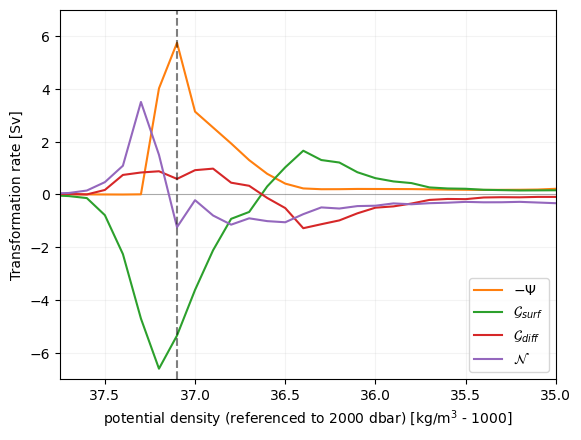

In [213]:
wmt = wmbs["sigma2"] 

plt.axhline(0., color="k", alpha=0.3, lw=0.8)

#(wmt['mass_tendency']*toSv).mean('time').plot(label=r"$\partial_{t} \mathcal{V}$", color="C0")
(-wmt['overturning']*toSv).mean('time').plot(label=r"$-\Psi$", color="C1")
(wmt['boundary_forcing']*toSv).mean('time').plot(label=r"$\mathcal{G}_{surf}$", color="C2")
(wmt['diffusion']*toSv).mean('time').plot(label=r"$\mathcal{G}_{diff}$", color="C3")
(wmt['numerical_errors']*toSv).mean('time').plot(label=r"$\mathcal{N}$", color="C4")
#(-wmt['mass_source']*toSv).mean('time').plot(label=r"$-\mathcal{S}$", color="C5")
#(wmt['geothermal']*toSv).mean('time').plot(label=r"$\mathcal{G}_{geo}$", color="C6")
#(wmt['frazil_ice']*toSv).mean('time').plot(label=r"$\mathcal{G}_{frazil}$", color="C7")

plt.legend()
plt.grid(True, alpha=0.15)
plt.ylabel("Transformation rate [Sv]")
plt.xlabel(r"potential density (referenced to 2000 dbar) [kg/m$^3$ - 1000]");

sigma2_max_overturning = (-wmt['overturning']).mean('time').idxmax()
plt.axvline(sigma2_max_overturning, color="k", linestyle="--", alpha=0.5)
plt.xlim(37.75, 35)
plt.ylim(-7, 7)
plt.legend(loc="lower right")

plt.savefig("../ncar_figures/antarctic_wmb_3", bbox_inches="tight", dpi=150)

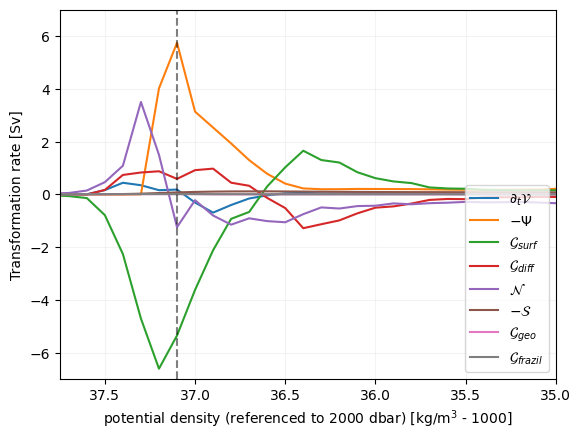

In [214]:
wmt = wmbs["sigma2"] 

plt.axhline(0., color="k", alpha=0.3, lw=0.8)

(wmt['mass_tendency']*toSv).mean('time').plot(label=r"$\partial_{t} \mathcal{V}$", color="C0")
(-wmt['overturning']*toSv).mean('time').plot(label=r"$-\Psi$", color="C1")
(wmt['boundary_forcing']*toSv).mean('time').plot(label=r"$\mathcal{G}_{surf}$", color="C2")
(wmt['diffusion']*toSv).mean('time').plot(label=r"$\mathcal{G}_{diff}$", color="C3")
(wmt['numerical_errors']*toSv).mean('time').plot(label=r"$\mathcal{N}$", color="C4")
(-wmt['mass_source']*toSv).mean('time').plot(label=r"$-\mathcal{S}$", color="C5")
(wmt['geothermal']*toSv).mean('time').plot(label=r"$\mathcal{G}_{geo}$", color="C6")
(wmt['frazil_ice']*toSv).mean('time').plot(label=r"$\mathcal{G}_{frazil}$", color="C7")

plt.legend()
plt.grid(True, alpha=0.15)
plt.ylabel("Transformation rate [Sv]")
plt.xlabel(r"potential density (referenced to 2000 dbar) [kg/m$^3$ - 1000]");

sigma2_max_overturning = (-wmt['overturning']).mean('time').idxmax()
plt.axvline(sigma2_max_overturning, color="k", linestyle="--", alpha=0.5)
plt.xlim(37.75, 35)
plt.ylim(-7, 7)
plt.legend(loc="lower right")

plt.savefig("../ncar_figures/antarctic_wmb_4", bbox_inches="tight", dpi=150)

### Baltic example

In [215]:
rho_ref = 1035.
toSv = 1.e-6/rho_ref

wmbs = {}
dts = ["monthly", "daily", "hourly"]
lams = ["heat", "salt", "sigma2"]

for dt in dts:
    wmbs[dt] = {}
    for lam in lams:
        wmbs[dt][lam] = xr.open_dataset(f"/work/hfd/codedev/xwmb/data/budget_intBaltic_{lam}_{dt}_natv_updated.nc")
        wmbs[dt][lam]["tendency"] += wmbs[dt][lam]["surface_mass_flux"]
        wmbs[dt][lam]["boundary_forcing"] += wmbs[dt][lam]["surface_mass_flux"]
        wmbs[dt][lam]["external_forcing"] += wmbs[dt][lam]["surface_mass_flux"]
        wmbs[dt][lam]["diabatic_forcing"] += wmbs[dt][lam]["surface_mass_flux"]

        wmbs[dt][lam]['numerical_mixing'] = (
            +wmbs[dt][lam].advection
            +wmbs[dt][lam].overturning
            +wmbs[dt][lam].mass_source
            -wmbs[dt][lam].residual_mass_tendency
        )

        wmbs[dt][lam]['volume_discretization_error'] = (
            +wmbs[dt][lam].residual_mass_tendency
            -wmbs[dt][lam].mass_tendency
            -wmbs[dt][lam].tendency
        )

        wmbs[dt][lam]['numerical_errors'] = (
            +wmbs[dt][lam].advection
            +wmbs[dt][lam].overturning
            +wmbs[dt][lam].mass_source
            -wmbs[dt][lam].mass_tendency
            -wmbs[dt][lam].tendency
        )

In [216]:
def plot_budget(wmt, ax=None):
    if ax is None:
        ax = plt.gca()
    
    ax.axhline(0., color="k", alpha=0.3, lw=0.8)

    (wmt['mass_tendency']*toSv).mean('time').plot(ax=ax, label=r"$\partial_{t} \mathcal{V}$", color="C0")
    (-wmt['overturning']*toSv).mean('time').plot(ax=ax, label=r"$-\Psi$", color="C1")
    (wmt['external_forcing']*toSv).mean('time').plot(ax=ax, label=r"$\mathcal{G}_{ext}$", color="C2")
    (wmt['diffusion']*toSv).mean('time').plot(ax=ax, label=r"$\mathcal{G}_{diff}$", color="C3")
    (wmt['numerical_errors']*toSv).mean('time').plot(ax=ax, label=r"$\mathcal{N}$", color="C4")
    (-wmt['mass_source']*toSv).mean('time').plot(ax=ax, label=r"$-\mathcal{S}$", color="C5")

    ax.legend()
    ax.grid(True, alpha=0.15)
    ax.set_ylabel("Transformation rate [Sv]")
    
    ax.legend(loc="lower right")

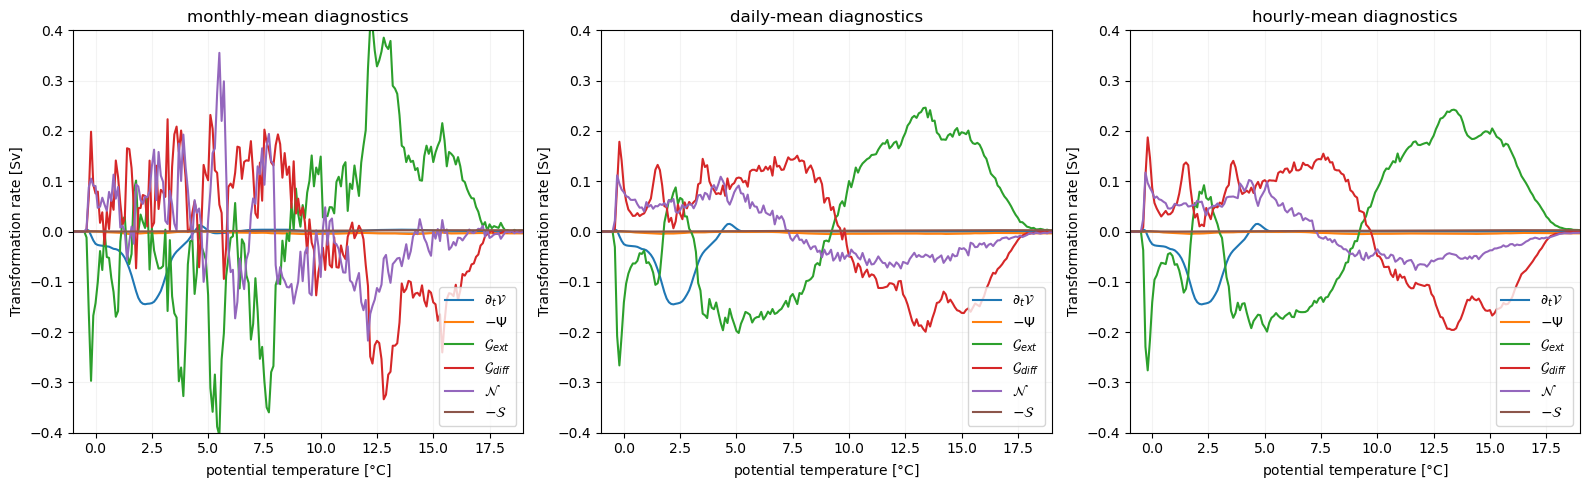

In [217]:
fig, axes = plt.subplots(1,3, figsize=(16, 5))
for i, dt in enumerate(dts, start=0):
    ax = axes[i]
    plot_budget(wmbs[dt]["heat"], ax=ax)
    ax.set_xlabel(r"potential temperature [$\degree$C]");
    ax.set_xlim(-1, 19)
    ax.set_ylim(-0.4, 0.4)
    ax.set_title(f"{dt}-mean diagnostics")
    
plt.tight_layout()
plt.savefig("../ncar_figures/Baltic_wmb_convergence_heat.png", bbox_inches="tight", dpi=150)

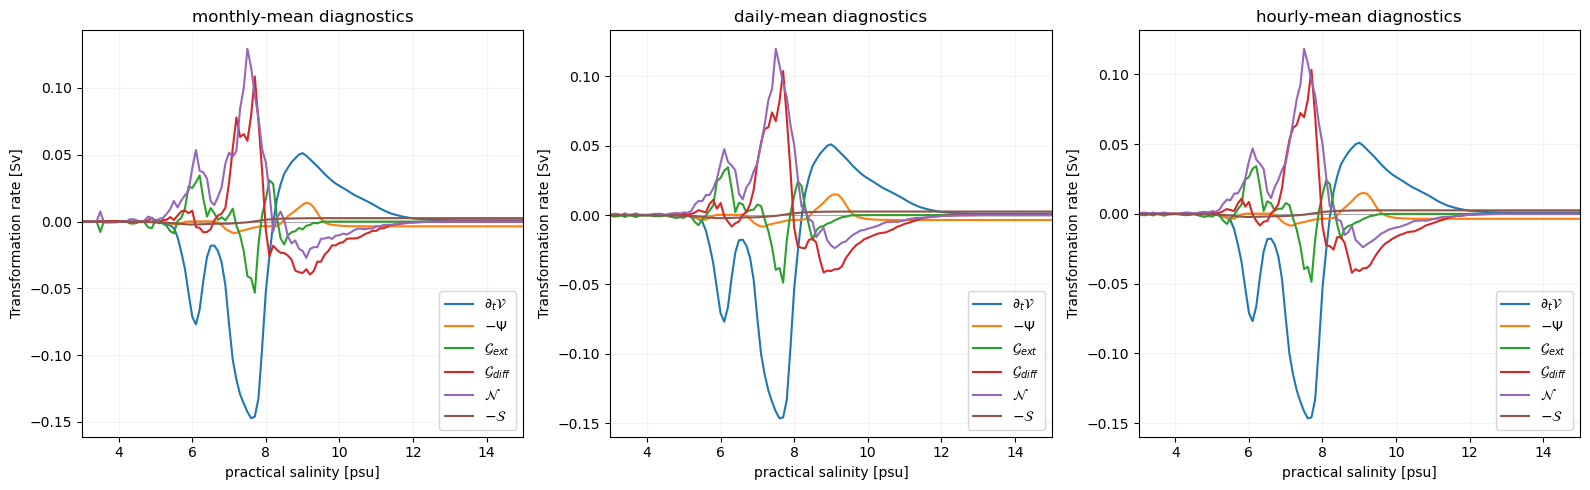

In [218]:
fig, axes = plt.subplots(1,3, figsize=(16, 5))
for i, dt in enumerate(dts, start=0):
    ax = axes[i]
    plot_budget(wmbs[dt]["salt"], ax=ax)
    ax.set_xlabel(r"practical salinity [psu]");
    ax.set_xlim(3, 15)
    ax.set_title(f"{dt}-mean diagnostics")

plt.tight_layout()
plt.savefig("../ncar_figures/Baltic_wmb_convergence_salt.png", bbox_inches="tight", dpi=150)

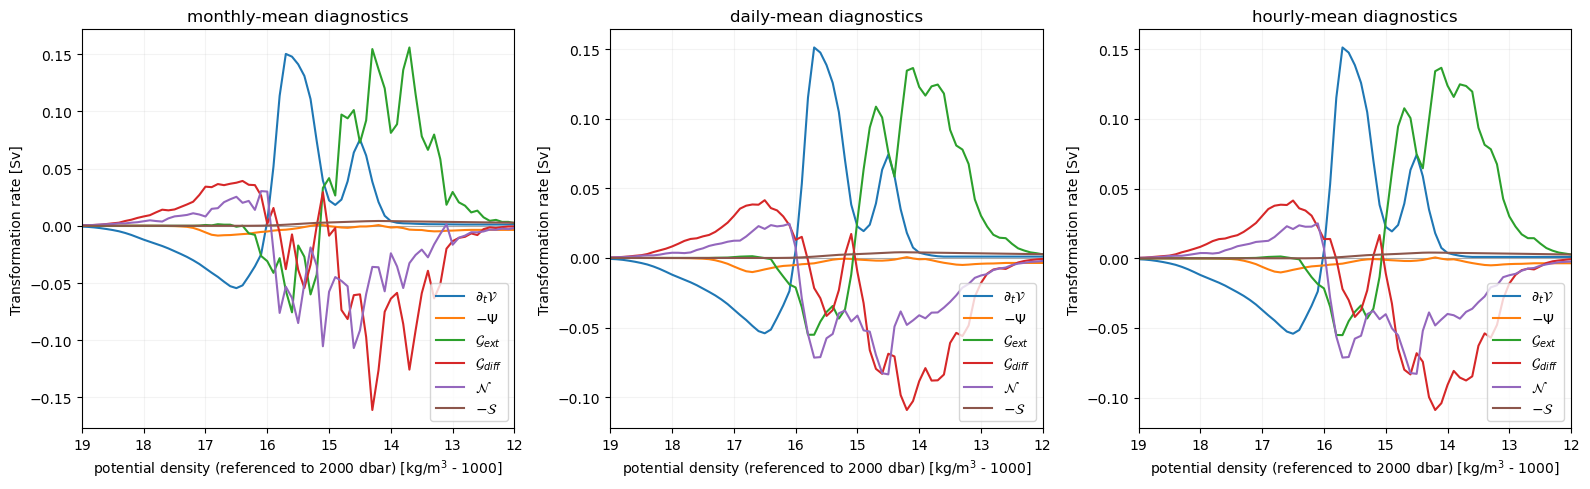

In [245]:
fig, axes = plt.subplots(1,3, figsize=(16, 5))
for i, dt in enumerate(dts, start=0):
    ax = axes[i]
    plot_budget(wmbs[dt]["sigma2"], ax=ax)
    ax.set_xlabel(r"potential density (referenced to 2000 dbar) [kg/m$^3$ - 1000]");
    ax.set_xlim(19, 12)
    ax.set_title(f"{dt}-mean diagnostics")
    
plt.tight_layout()
plt.savefig("../ncar_figures/Baltic_wmb_convergence_sigma2.png", bbox_inches="tight", dpi=150)

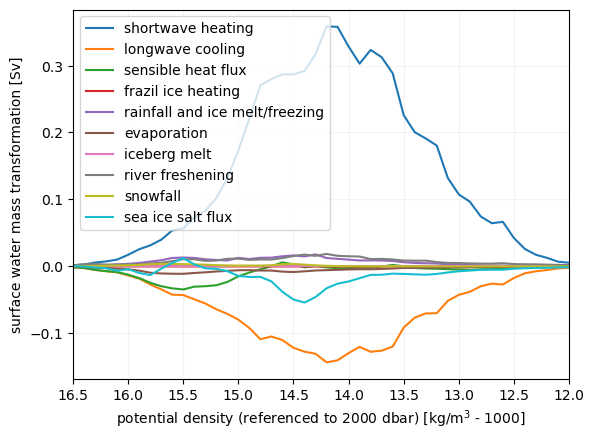

In [205]:
wmt = wmbs['hourly']['sigma2']
(wmt['surface_flux_shortwave_heat']*toSv).mean('time').plot(label=r"shortwave heating")
(wmt['surface_flux_longwave_heat']*toSv).mean('time').plot(label=r"longwave cooling")
(wmt['surface_flux_sensible_heat']*toSv).mean('time').plot(label=r"sensible heat flux")
(wmt['surface_flux_frazil_ice_heat']*toSv).mean('time').plot(label=r"frazil ice heating")
(wmt['surface_mass_flux_rain_and_ice_salt']*toSv).mean('time').plot(label=r"rainfall and ice melt/freezing")
(wmt['surface_mass_flux_evaporation_salt']*toSv).mean('time').plot(label=r"evaporation")
(wmt['surface_mass_flux_icebergs_salt']*toSv).mean('time').plot(label=r"iceberg melt")
(wmt['surface_mass_flux_rivers_salt']*toSv).mean('time').plot(label=r"river freshening")
(wmt['surface_mass_flux_snow_salt']*toSv).mean('time').plot(label=r"snowfall")
(wmt['surface_flux_basal_salt']*toSv).mean('time').plot(label=r"sea ice salt flux")
plt.legend()
plt.ylabel("surface water mass transformation [Sv]")
plt.xlabel(r"potential density (referenced to 2000 dbar) [kg/m$^3$ - 1000]");
plt.xlim(16.5, 12)
plt.grid(True, alpha=0.15)
plt.savefig("../ncar_figures/Baltic_swmt.png", bbox_inches="tight", dpi=150)